# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Comics Characters on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Comic Book Characters Network
* Properties of the network structure, including how univere-origin and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

---
# Part A: Let's  visualise!

*Exercise 1*: Build the right graph for visualization. 

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2022/blob/master/lectures/Week4.ipynb) for details. 

This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4:

>1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia pages. 
>   * **Additionally**, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 2k nodes and more than 15k edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component
>2. As you build the graph, store the attributes of the nodes (remember the `universe` from the past week). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each character's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [84]:
#%matplotlib notebook

In [85]:
!pip install networkx
import networkx as nx
import pandas as pd
import pickle
import regex as re

In [86]:
df_DC = pd.read_pickle('/Users/lucialarraona/Desktop/socialgraphs2022/lectures/ouputs/pickle_DC_out.pkl')
df_marvel = pd.read_pickle('/Users/lucialarraona/Desktop/socialgraphs2022/lectures/ouputs/pickle_marvel_out.pkl')

In [87]:
df_marvel.head()

,CharacterName,WikiLink,text,nodes,edges
0,Abomination,Abomination (character),{{For|the biblical term|Abomination (Bible)}}\...,"[Red Hulk, Silver Surfer, Glenn Talbot, MODOK,...","[(Abomination (character), Red Hulk), (Abomina..."
1,Absorbing Man,Absorbing Man,{{Short description|Marvel Comics fictional ch...,"[Black Bolt, Spider-Man, She-Hulk, Ethan Edwar...","[(Absorbing Man, Black Bolt), (Absorbing Man, ..."
5,Achebe,Achebe (comics),#REDIRECT [[Achebe (character)]]\n\n{{Redirect...,[],[]
13,Agent,Agent (comics),{{Short description|Fictional character in Mar...,"[Luke Cage, Carol Danvers]","[(Agent (comics), Luke Cage), (Agent (comics),..."
14,Agent X,Agent X (Marvel Comics),{{short description|Fictional comic book chara...,"[Deadpool, Deadpool, Deadpool, X-Statix, Punis...","[(Agent X (Marvel Comics), Deadpool), (Agent X..."


In [88]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(df_marvel['WikiLink'].values, universe="Marvel")
G.add_nodes_from(df_DC['WikiLink'].values, universe="DC")
print(G)


col_one_list = df_marvel['edges'].tolist()
col_one_listDC=(df_DC['edges'].tolist())

edges_values_list= col_one_list + col_one_listDC

def flatten(l):
    return [item for sublist in l for item in sublist]

edges_values_tuples = flatten(edges_values_list)

G.add_edges_from(edges_values_tuples)
print(G)


DiGraph with 2303 nodes and 0 edges
DiGraph with 2303 nodes and 12869 edges


In [89]:
attributes_variable_DC = {row['WikiLink']:{"content" : len(re.findall(r'\w+',row['text']))} for index, row in df_DC.iterrows()}
attributes_variable_marvel = {row['WikiLink']:{"content" : len(re.findall(r'\w+',row['text']))} for index, row in df_marvel.iterrows()}

nx.set_node_attributes(G, attributes_variable_DC)
nx.set_node_attributes(G, attributes_variable_marvel)

In [90]:
attribute = nx.get_node_attributes(G, "content")

In [91]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc).copy()
GCC_U = GCC.to_undirected()

*Exercise 2:* Let's build a simple visualization of network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises
>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the network resulting undirected. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `universe` attribute. If an edge connects two nodes from Marvel universe assign `color_a`, if the edge connects two nodes from DC universe assign `color_b`, in case a link connects nodes from disparate universes, cases assign `color_c`. (Here, you get to decide on the colors.)

In [140]:
import matplotlib.pyplot as plt
DG = G.subgraph(largest_cc)
UG = DG.to_undirected()
mapping = {"Marvel": 'pink', "DC": 'purple'}
colors = [mapping[UG.nodes[n]['universe']] for n in UG.nodes()]
d = dict(UG.degree)
mapping

{'Marvel': 'pink', 'DC': 'purple'}

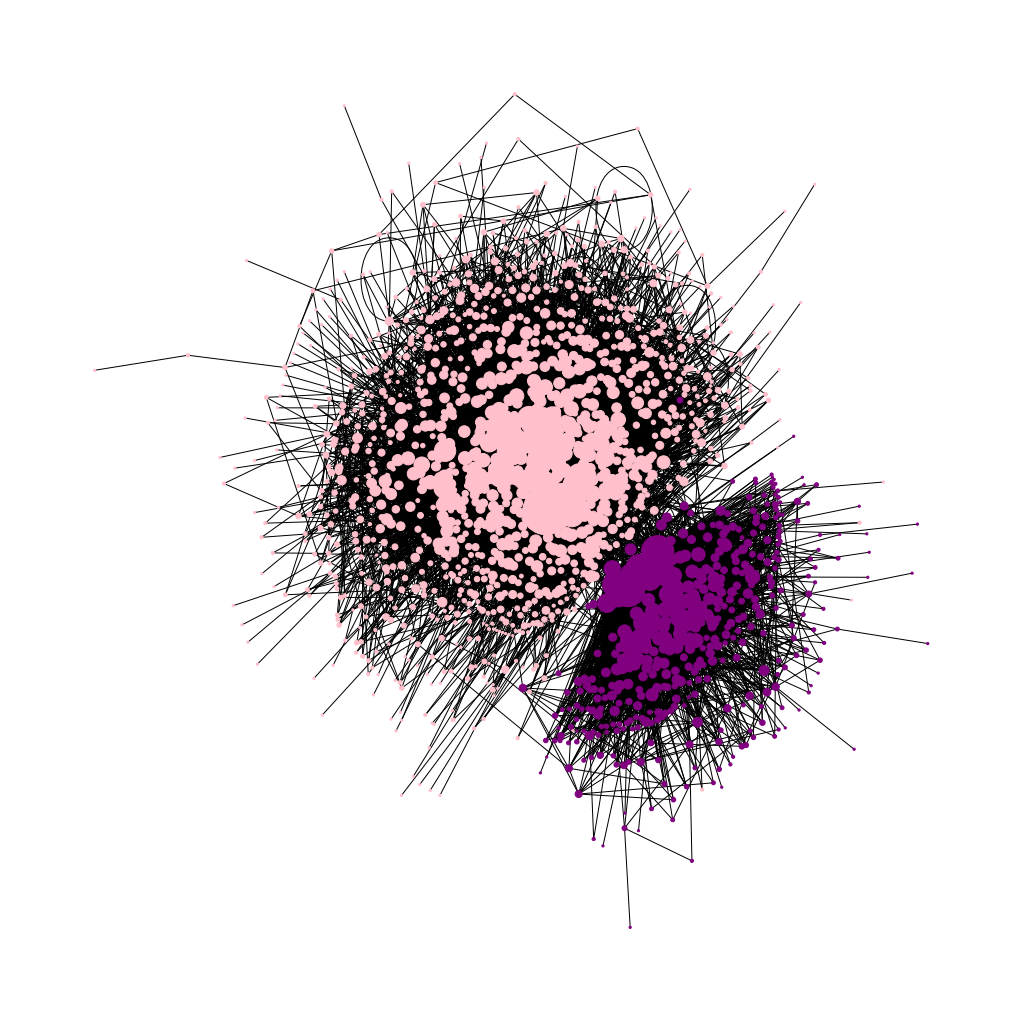

In [141]:
plt.figure(figsize=(14,14))
nx.draw_kamada_kawai(
    UG,
    nodelist = list(d.keys()),
    node_size = [v*5 for v in list(d.values())],
    node_color = colors
)
plt.show()

*Exercise 3:* We can make even better visualisations with `ForceAtlas2` package. (By "better" we mean "more beautiful" of course, **but** better also means more useful in terms of understanding the network. A good visualization that really captures structure in the graph can help you understand the network. )

>1. The [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps calculate more aesthetically pleasing positions for the nodes (see what the result looks like below).
>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node. You can then feed those coordinates to NetworkX (see below).
> * Visualize the network using the [NetworkX draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Node size should depend on the node *degree*
>   * **Optional**: Edge colour should depend on the `universe` attribute. If an edge connects nodes from Marvel universe assign `color_a`, if the edge connects nodes from DC universe assign `color_b`, in other cases assign `color_c`
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot below, the red nodes seem to split into two sub-clusters: What's going on there?

![Network](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/week5_fa2_a.png?raw=true)

In [94]:
!pip install fa2
# doing it locally in lu's computer 

In [161]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)

# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC_U, pos=None, iterations=8000)

100%|███████████████████████████████████████████████████████████| 8000/8000 [02:24<00:00, 55.19it/s]

BarnesHut Approximation  took  54.91  seconds
Repulsion forces  took  80.14  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  3.68  seconds
AdjustSpeedAndApplyForces step  took  2.76  seconds


In [162]:
from itertools import count

# Get unique groups based on attributes (imagine there where more than 2, maybe for the future)
groups = set(nx.get_node_attributes(GCC_U,'universe').values())
mapping = dict(zip(sorted(groups),count()))
nodes = GCC_U.nodes()
colors = [mapping[GCC_U.nodes[n]['universe']] for n in nodes]

# node size according to degrees
d = dict(nx.degree(GCC_U))

In [163]:
mapping = {"Marvel": 'red', "DC": 'black'}
colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]

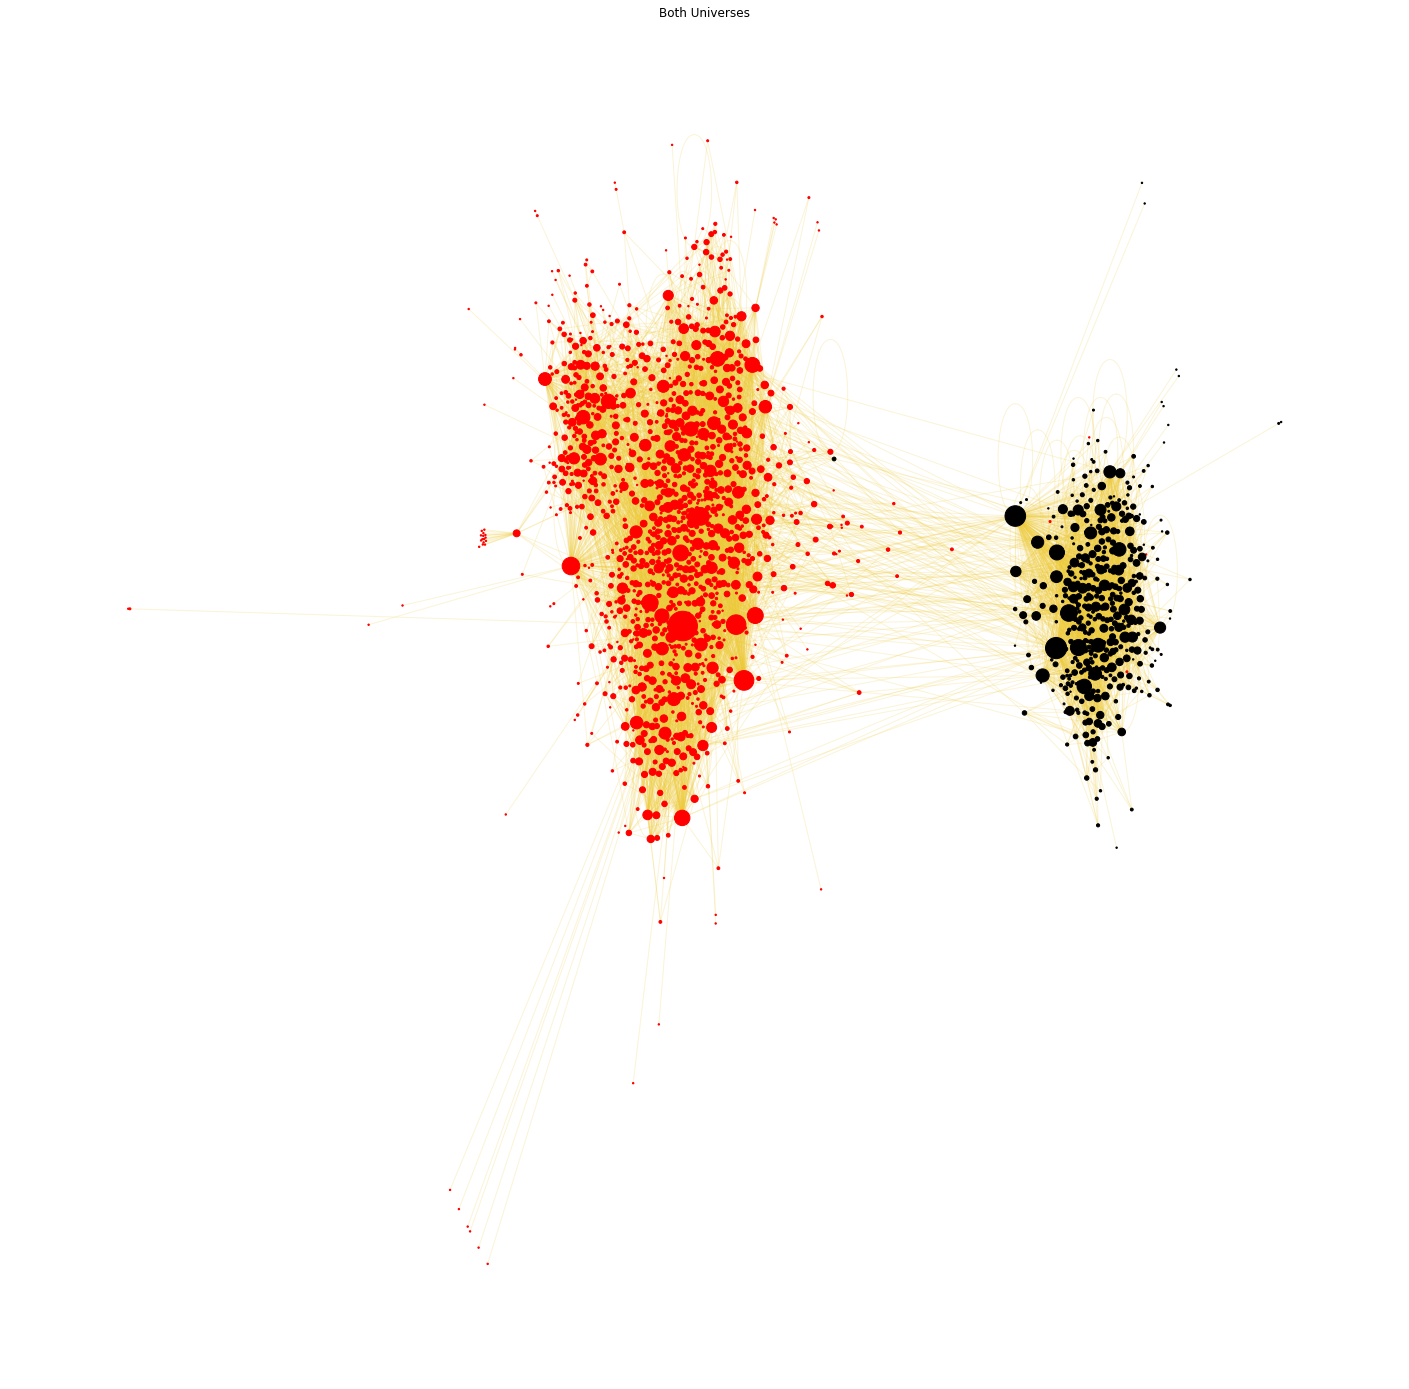

In [164]:
plt.figure(3,figsize=(25,25)) 


nc = nx.draw_networkx_nodes(GCC_U, 
                       positions, 
                       node_size=[v * 2 for v in d.values()], 
                       label=True,  
                       node_color=colors,
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(GCC_U, 
                            positions, 
                            edge_color="#ECC836", 
                            alpha=0.2)

#lb = nx.draw_networkx_labels(GCC_U,
#                            positions,
#                            e)

plt.axis('off')
plt.title('Both Universes')
plt.show()

*Exercise 4*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

>1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>   * Consider the set of neighbours pointing towards the node found above. 
>   * What is the relation between the characters you identified and their network neighbours? (e.g. do they appear in the same comics?, are they opponents?, etc ...). You don't need to come up with a grand theory of comics here, I just want you to think about how links arise, why the links are there.
>   * Repeat the exercise for the largest out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
>5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
>6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens? 

In [142]:
len(G.nodes())

2303

In [144]:
# Nodes with the highest in-degree (k-in)

# k-in represents the number of other characters that point to the selected character

G_in_degrees = list(G.in_degree(G.nodes()))
G_in_degrees_dict={key:value for key,value in G_in_degrees}


G_out_degrees = list(G.out_degree(G.nodes()))
G_out_degrees_dict={key:value for key,value in G_out_degrees}

In [145]:
def get_maxmin_degree(d, max_degree = True):
    """
    get_maxmin_degree() extracts the node and the degree of a dictionary of given tuples from a graph

    :param d (dictionary): dictionary of nodes and their degree
    :param max_degree (boolean): True if max degree, False if min degree

    :returns: tuple (node,degree) with max or min value

    """
    if max_degree == True:
        max_key = max(d, key=d.get)
        reslt_pair = tuple([max_key,d[max_key]])
        #print(reslt_pair)
    else:
        min_key = min(d, key=d.get)
        reslt_pair = tuple([min_key,d[min_key]])
        #print(reslt_pair)
    return reslt_pair

In [146]:
node_max_degree = get_maxmin_degree(G_in_degrees_dict, max_degree= True)   
print (f'The node with the max in degree is {node_max_degree}')

node_max_degree = get_maxmin_degree(G_out_degrees_dict, max_degree= True)   
print (f'The node with the max out degree is {node_max_degree}')

The node with the max in degree is ('Spider-Man', 433)
The node with the max out degree is ('Iron Man|Iron Man (Ultimate Marvel character)|Tony Stark (Marvel Cinematic Universe)', 54)


In [147]:
sorted_in_degree = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
sorted_out_degree = sorted(G.out_degree, key=lambda x: x[1], reverse=True)

In [149]:
print(f" Superheroes with the highest in-degree:\n{sorted_in_degree[:5]}")
print('\n')
print(f" Superheroes with the highest out-degree:\n{sorted_out_degree[:5]}")

 Superheroes with the highest in-degree:
[('Spider-Man', 433), ('Superman', 223), ('Batman', 209), ('Doctor Strange', 184), ('Doctor Doom', 177)]


 Superheroes with the highest out-degree:
[('Iron Man|Iron Man (Ultimate Marvel character)|Tony Stark (Marvel Cinematic Universe)', 54), ('Norman Osborn|Norman Osborn (Sam Raimi film series)', 42), ('Doctor Octopus', 41), ('She-Hulk', 41), ('Mary Jane Watson|Mary Jane Watson (Sam Raimi film series)', 40)]


In [150]:
G_in_degrees_dict['Norman Osborn|Norman Osborn (Sam Raimi film series)']

0

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

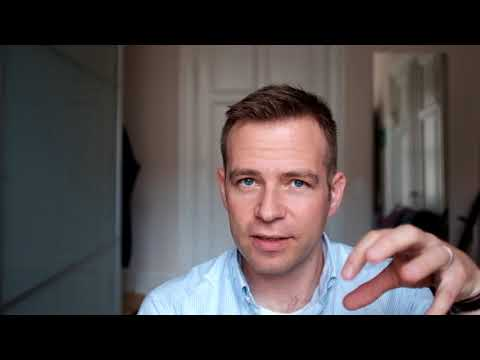

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 5:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * A long time ago, a group of scientists analyzed the network spanned by ***all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
>3. Create a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
>5. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version. Which questions? Can you think of examples when the in/out distinction doesn't matter.
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>   * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words

In [151]:
from scipy import stats
import numpy as np


#in-degree

in_degree_list = [val for (node, val) in DG.in_degree()]
in_mean = np.mean(in_degree_list)
in_median =np.median(in_degree_list)
in_mode = stats.mode(in_degree_list)[0]
in_min = np.min(in_degree_list)
in_max = np.max(in_degree_list)
print('In-degree statistics:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')

2022-09-30 14:13:24,964 [95968] WARNING  py.warnings:109: [JupyterRequire] /var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_95968/2763349303.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  in_mode = stats.mode(in_degree_list)[0]



In-degree statistics:
Mean: 7.624184943687018
Median:1.0
Mode:[0]
Min:0
Max:433


In [152]:
#out-degree

out_degree_list = [val for (node, val) in DG.out_degree()]
out_mean = np.mean(out_degree_list)
out_median =np.median(out_degree_list)
out_mode = stats.mode(out_degree_list)[0]
out_min = np.min(out_degree_list)
out_max = np.max(out_degree_list)
print('Out-degree statistics:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')


2022-09-30 14:13:25,005 [95968] WARNING  py.warnings:109: [JupyterRequire] /var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_95968/4159121453.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  out_mode = stats.mode(out_degree_list)[0]



Out-degree statistics:
Mean: 7.624184943687018
Median:1.0
Mode:[0]
Min:0
Max:433


In [153]:
# Marvel in-degree

in_deg_marvel = [val for (node, val) in DG.in_degree() if DG.nodes[node]['universe'] == 'Marvel']

in_mean = np.mean(in_deg_marvel)
in_median =np.median(in_deg_marvel)
in_mode = stats.mode(in_deg_marvel)[0]
in_min = np.min(in_deg_marvel)
in_max = np.max(in_deg_marvel)
print('In-degree statistics for Marvel:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')


2022-09-30 14:13:35,908 [95968] WARNING  py.warnings:109: [JupyterRequire] /var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_95968/2743579576.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  in_mode = stats.mode(in_deg_marvel)[0]



In-degree statistics for Marvel:
Mean: 7.323390894819466
Median:1.0
Mode:[0]
Min:0
Max:433


In [154]:
# Marvel-out

out_deg_marvel = [val for (node, val) in DG.out_degree() if DG.nodes[node]['universe'] == 'Marvel']

in_mean = np.mean(out_deg_marvel)
in_median =np.median(out_deg_marvel)
in_mode = stats.mode(out_deg_marvel)[0]
in_min = np.min(out_deg_marvel)
in_max = np.max(out_deg_marvel)
print('Out-degree statistics for Marvel:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')

2022-09-30 14:13:36,174 [95968] WARNING  py.warnings:109: [JupyterRequire] /var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_95968/369068705.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  in_mode = stats.mode(out_deg_marvel)[0]



Out-degree statistics for Marvel:
Mean: 7.372841444270016
Median:5.0
Mode:[1]
Min:0
Max:54


In [155]:
# DC in-degree

in_deg_dc = [val for (node, val) in DG.in_degree() if DG.nodes[node]['universe'] == 'DC']

in_mean = np.mean(in_deg_dc)
in_median =np.median(in_deg_dc)
in_mode = stats.mode(in_deg_dc)[0]
in_min = np.min(in_deg_dc)
in_max = np.max(in_deg_dc)
print('In-degree statistics for DC:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')

2022-09-30 14:13:37,547 [95968] WARNING  py.warnings:109: [JupyterRequire] /var/folders/0l/b401ys7x3v303b2m4jkcr32r0000gn/T/ipykernel_95968/300366773.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  in_mode = stats.mode(in_deg_dc)[0]



In-degree statistics for DC:
Mean: 8.552058111380145
Median:2.0
Mode:[0]
Min:0
Max:223


In [ ]:
# DC-out

out_deg_dc = [val for (node, val) in DG.out_degree() if DG.nodes[node]['universe'] == 'DC']

in_mean = np.mean(out_deg_dc)
in_median =np.median(out_deg_dc)
in_mode = stats.mode(out_deg_dc)[0]
in_min = np.min(out_deg_dc)
in_max = np.max(out_deg_dc)
print('Out-degree statistics for DC:')
print(f"Mean: {in_mean}")
print(f'Median:{in_median}')
print(f'Mode:{in_mode}')
print(f'Min:{in_min}')
print(f'Max:{in_max}')

In [ ]:
!pip install powerlaw

In [ ]:
import powerlaw
in_fit = powerlaw.Fit(in_degree_list).alpha
print(in_fit)
out_fit = powerlaw.Fit(out_degree_list).alpha
print(out_fit)

In [ ]:
plt.scatter(in_degree_list, out_degree_list)

In [ ]:
#heatmap
heatmap, xedges, yedges = np.histogram2d(in_degree_list, out_degree_list, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
#content length

#scipy.stats.spearmanr(a, b=None, axis=0, nan_policy='propagate', alternative='two-sided')[source]

*Exercise 6:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. Meanwhile, **for this exercise use either the DC or Marvel Network alone (i.e. only a single universe). This it will help you to see the differences).**
>1. Find the 5 most central characters according to degree centrality. 
>   * Repeat Exercise 2 or 3 from part A above for your new sub-network (depending on which visualization method you liked the most), but with our new network.
>1. Find the 5 most central characters according to betweenness centrality. 
>   * Repeat Exercise 2 or 3 once again. However, this time use *betweenness centrality* to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
>2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>   * Repeat Exercise 2 or 3 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
>3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>    * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
>4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
>4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `content length` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>5. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

---

> * **Optional** (but cool). What about betweenness centrality in the full network? Create a visualization of the network using Force Atlas 2, where you set the size of nodes to scale according to their betweenness centrality. Describe in your own words what you learn from that plot.

In [58]:
# Just the visualizations bc they don't work in deepnote 

# Import the subgraphs
subDC = nx.read_gpickle('/Users/lucialarraona/Desktop/socialgraphs2022/lectures/ouputs/DC_subgraph.gpickle')
subMarvel = nx.read_gpickle('/Users/lucialarraona/Desktop/socialgraphs2022/lectures/ouputs/marvel_subgraph.gpickle')

# Extract giant component of DC

largest_cc_dc = max(nx.weakly_connected_components(subDC), key=len)
GCC_dc = subDC.subgraph(largest_cc_dc).copy()
subDC_GCC_U = GCC_dc.to_undirected()

# Extract giant component of marvel

#largest_cc_marvel = max(nx.weakly_connected_components(subMarvel), key=len)
#GCC_marvel = subDC.subgraph(largest_cc_marvel).copy()
#subMarvel_GCC_U = GCC_marvel.to_undirected()


forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)





# Gets positions of the nodes 
positions_subDC = forceatlas2.forceatlas2_networkx_layout(subDC_GCC_U, pos=None, iterations=2000)
positions_subMarvel = forceatlas2.forceatlas2_networkx_layout(subMarvel, pos=None, iterations=2000)

  1%|▍                                                            | 15/2000 [00:00<00:28, 68.80it/s]

BarnesHut Approximation  took  2.01  seconds
Repulsion forces  took  3.74  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


100%|███████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.79it/s]

BarnesHut Approximation  took  13.15  seconds
Repulsion forces  took  24.30  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.19  seconds
AdjustSpeedAndApplyForces step  took  0.75  seconds


In [59]:
d_dc=nx.degree_centrality(subDC_GCC_U)
d_m=nx.degree_centrality(subMarvel)

sorted_centrality_DC = sorted(d_dc.items(), key=lambda x: x[1], reverse=True)
sorted_centrality_M = sorted(d_m.items(), key=lambda x: x[1], reverse=True)

print(f" Superheroes with the highest centrality DC:\n{sorted_centrality_DC[:5]}")
print(f" Superheroes with the highest centrality Marvel:\n{sorted_centrality_M[:5]}")


 Superheroes with the highest centrality DC:
[('Superman', 0.49999999999999994), ('Batman', 0.4757281553398058), ('Wonder Woman', 0.30339805825242716), ('Lex Luthor', 0.2961165048543689), ('Green Lantern', 0.25728155339805825)]
 Superheroes with the highest centrality Marvel:
[('Spider-Man', 0.25), ('Doctor Strange', 0.11995515695067265), ('Doctor Doom', 0.11939461883408072), ('She-Hulk', 0.10145739910313901), ('Deadpool', 0.0913677130044843)]


In [67]:
bc_dc=nx.betweenness_centrality(subDC_GCC_U)
bc_m=nx.betweenness_centrality(subMarvel)

sorted_b_centrality_DC = sorted(bc_dc.items(), key=lambda x: x[1], reverse=True)
sorted_b_centrality_M = sorted(bc_m.items(), key=lambda x: x[1], reverse=True)

print(f" Superheroes with the highest betweennes centrality DC:\n{sorted_b_centrality_DC[:5]}")
print(f" Superheroes with the highest betweennes centrality Marvel:\n{sorted_b_centrality_M[:5]}")

 Superheroes with the highest betweennes centrality DC:
[('Batman', 0.20305530496881322), ('Superman', 0.1946269922191935), ('Green Lantern', 0.06911034278872094), ('Wonder Woman', 0.06279136566482808), ('Lex Luthor', 0.049861088456808984)]
 Superheroes with the highest betweennes centrality Marvel:
[('Spider-Man', 0.026770621222497112), ('Doctor Doom', 0.018635390219063252), ('Doctor Strange', 0.01697887515568553), ('She-Hulk', 0.01619252115844943), ('Red Skull', 0.012144491848755955)]


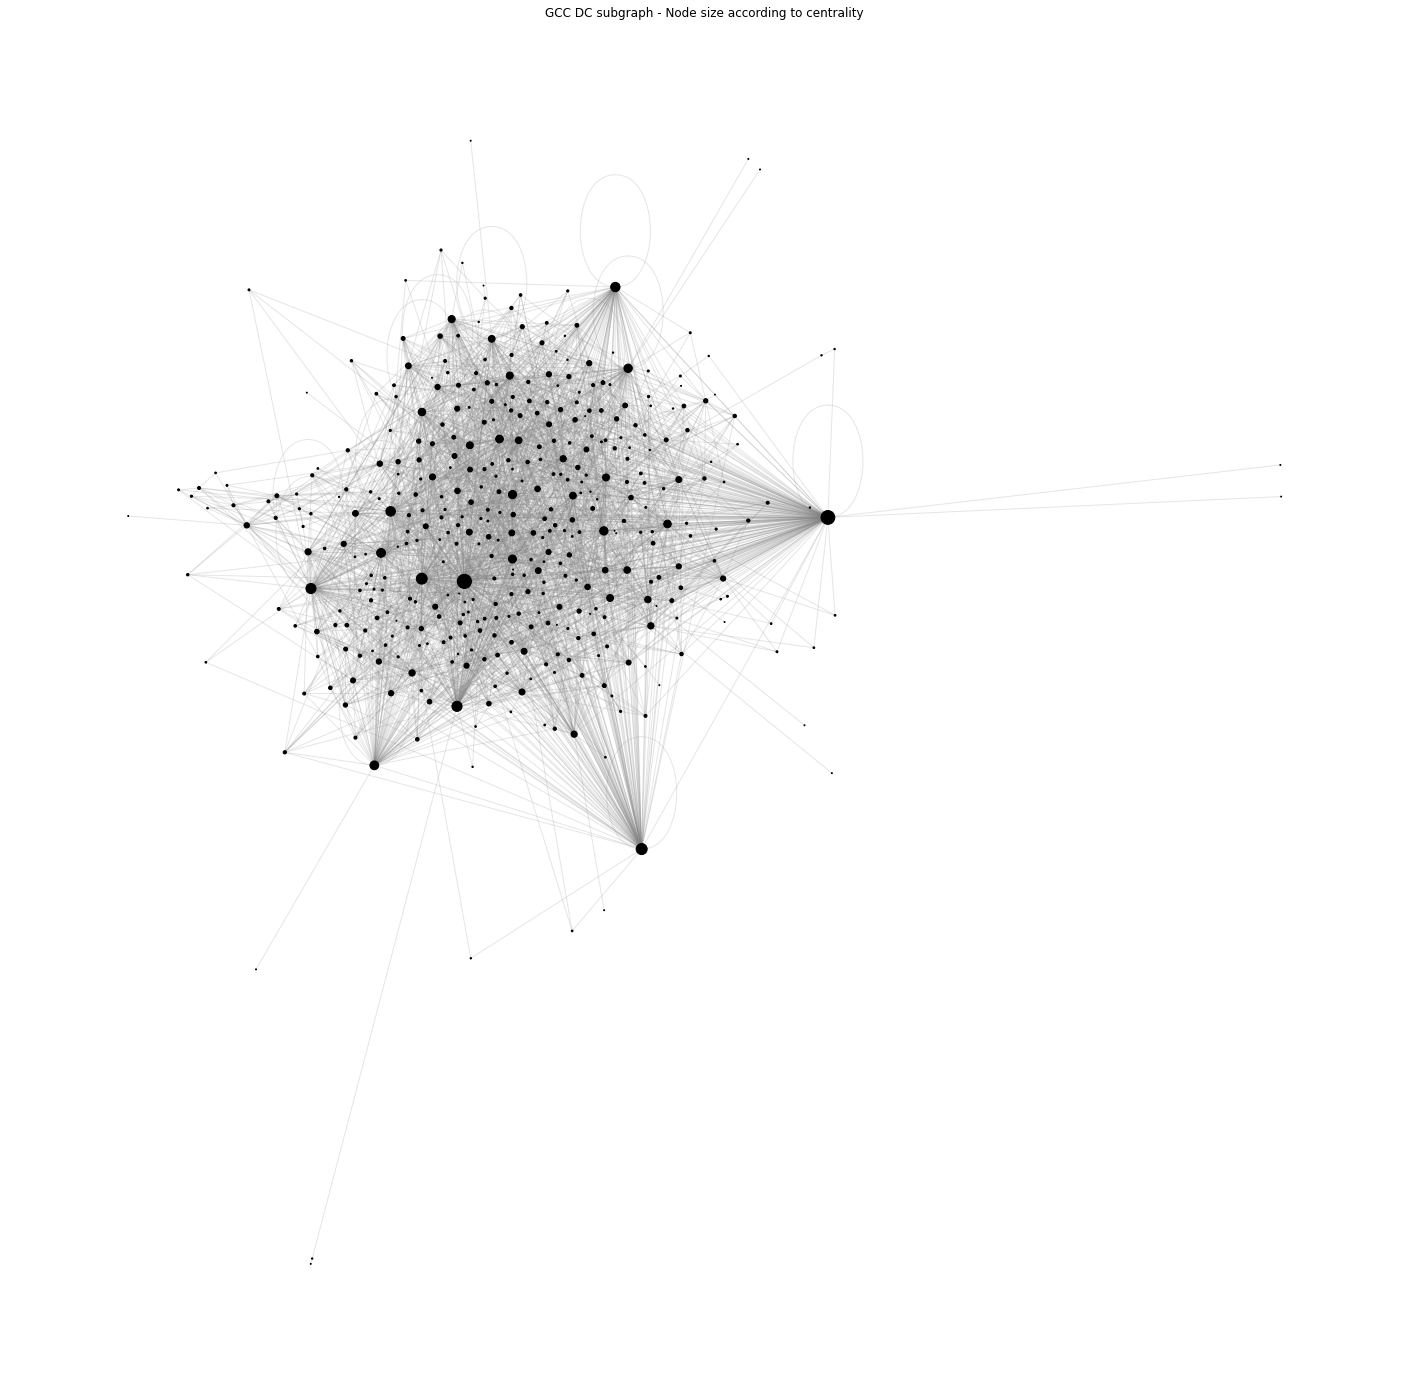

In [69]:
# Subgraph DC 

plt.figure(3,figsize=(25,25)) 


nc = nx.draw_networkx_nodes(subDC_GCC_U, 
                       positions_subDC, 
                       node_size=[v * 400 for v in d_dc.values()], 
                       label=True,  
                       node_color='black',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(subDC_GCC_U, 
                            positions_subDC, 
                            edge_color="gray", 
                            alpha=0.2)

plt.axis('off')
plt.title('GCC DC subgraph - Node size according to centrality')
plt.show()

In [ ]:
# Subgraph DC 
"""
plt.figure(3,figsize=(25,25)) 


nc = nx.draw_networkx_nodes(subMarvel, 
                       positions_subMarvel, 
                       node_size=[v * 400 for v in d_m.values()], 
                       label=True,  
                       node_color='red',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(subMarvel, 
                            positions_subMarvel, 
                            edge_color="gray", 
                            alpha=0.2)

plt.axis('off')
plt.title('GCC Marvel subgraph')
plt.show()

"""

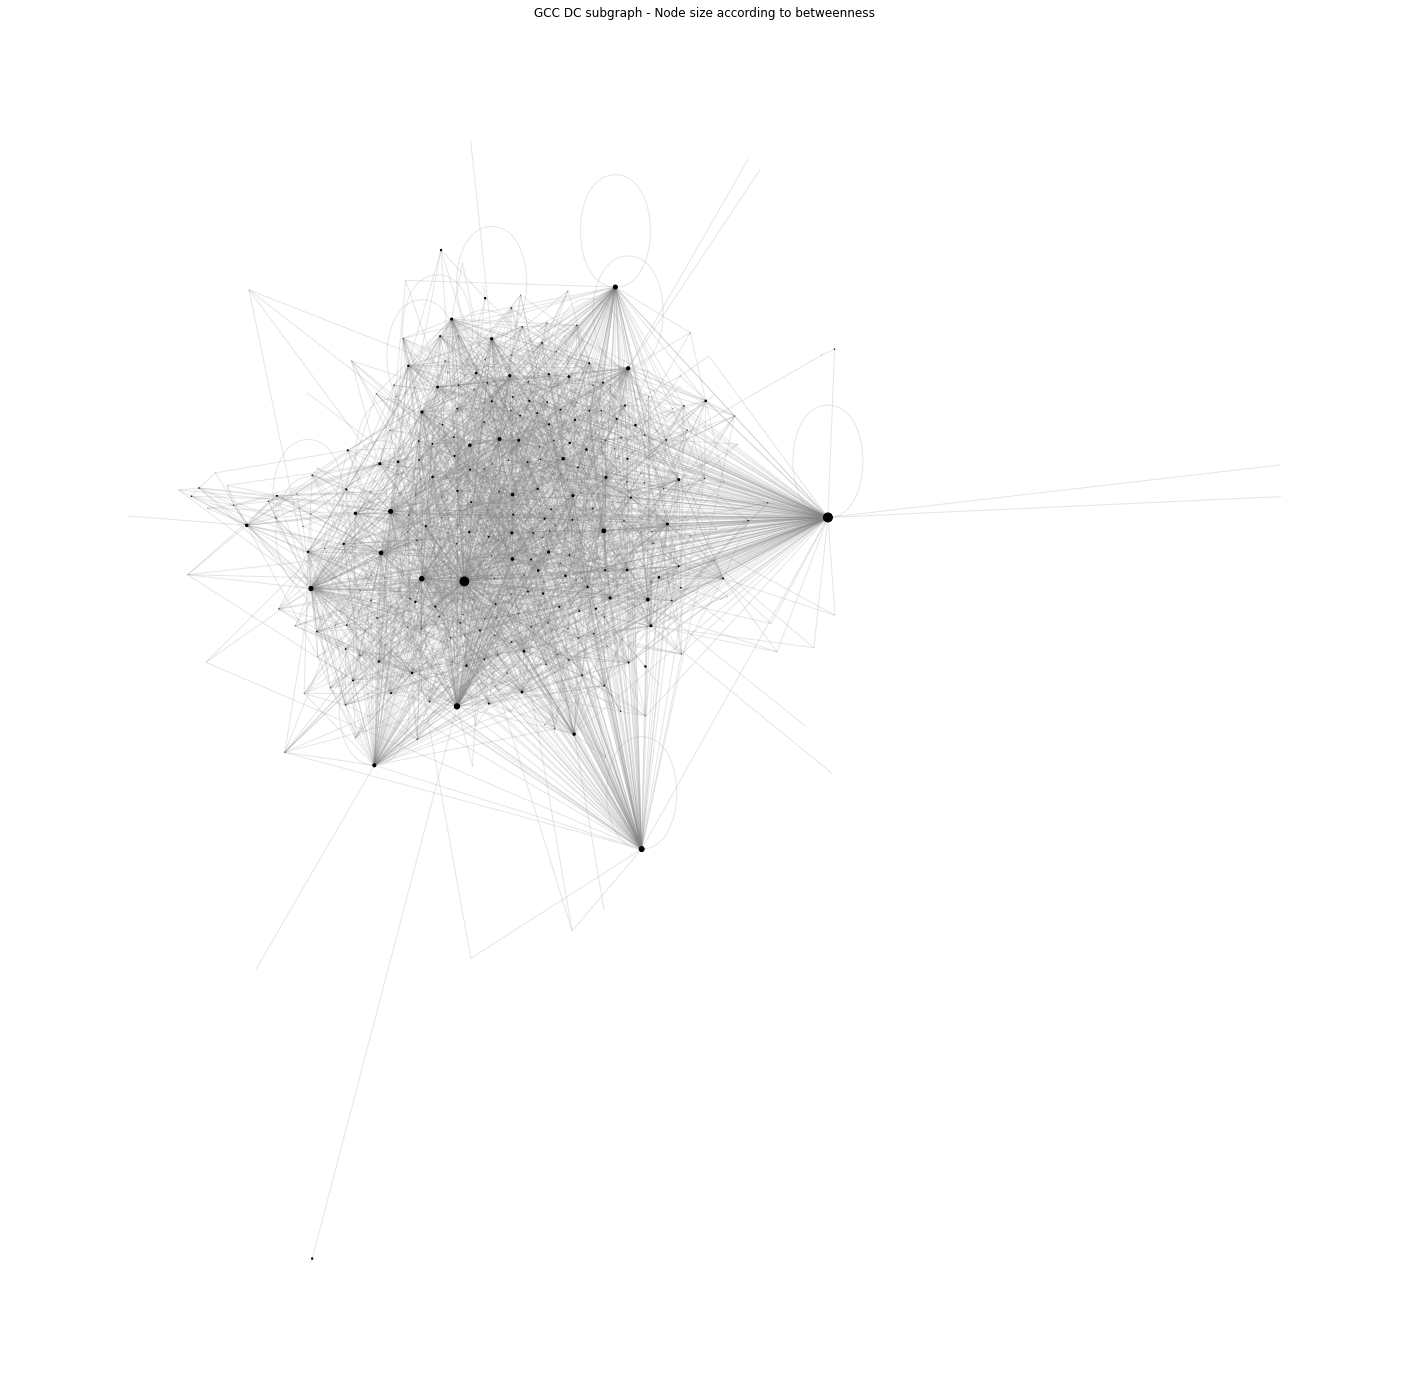

In [71]:
# Now with betweenness for DC:


plt.figure(4,figsize=(25,25)) 


nc = nx.draw_networkx_nodes(subDC_GCC_U, 
                       positions_subDC, 
                       node_size=[v * 400 for v in bc_dc.values()], 
                       label=True,  
                       node_color='black',
                       #cmap=plt.cm.plasma_r, 
                       )

ec = nx.draw_networkx_edges(subDC_GCC_U, 
                            positions_subDC, 
                            edge_color="gray", 
                            alpha=0.2)

plt.axis('off')
plt.title('GCC DC subgraph - Node size according to betweenness')
plt.show()

*Exercise 7*: Does a universe of a character play a role in the network as a whole? Now, let us explore if and how the universes shape the network (use full network).

**Note**. We explore this question using a general framework where we shuffle properties of nodes to create ensembles of networks to which we can compare our observed network. This is a version of the [permutation test](https://en.wikipedia.org/wiki/Permutation_test); don't worry if this all sounds fancy, we will guide you through all the steps..

>1. Compute the average node centrality for Marvel and DC characters respectively (choose your favourite centrality measure), let's call these $C_\textrm{marvel}$ and $C_\textrm{DC}$, where $C = \sum_{n  \in \textrm{universe}} c_n$ and the centrality of node $n$ is $c_{n}$. Which universe has the more central characters on average? (These are the real-world values you will be comparing to the shuffeled/permuted networks below.)
>2. Now we build a single comparison graph: Create a version of the full graph $R$, where the association between nodes and universes is shuffled (so in $R$ it is arbitrary which universe a character belongs to, but we maintain the same number of Marvel/DC characters as in the original graph). Compute the average centrality of DC and Marvel nodes for the $R$ graph, we can call these $C_\textrm{marvel}(R)$ and $C_\textrm{DC}(R)$. (This is one pair of values to compare to the real values $C_\textrm{marvel}$ and $C_\textrm{DC}$).
>   * **Hint**: The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (resulting in 1000 graphs $R_1 \ldots R_{1000}$) and plot two histograms, one histogram with values $\{C_\textrm{marvel}(R_1) \ldots C_\textrm{marvel}(R_{1000})\}$, which you can compare to $C_\textrm{marvel}$ and create the same plot for the DC characters based on the DC networks. The cool thing here is now you can compare your value from the real network to a *distribution* of averages from the ensemble of shuffled networks - you can answer questions along the lines of 'are the real values typical, as in situation **A** in the figure below, or rare as in situation **B** below'). Now it's your turn
>4. What is going on with the average centralities of the Marvel / DC characters relative to the ensemble of networks where universe assignments have been shuffled? Think about your results, what could be possible explanations for what you observe?

![a visual explanation](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/main/files/permutation.jpg)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bb8bd0b6-4d87-4bed-87c7-5404ec14f478' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>